## Modules
Needed to use non-Python functionalities already programmed by someone else.

In [1]:
# Used to cast the polygons into np.arrays and afterwards transpose them easily with the .T function
import numpy as np
import matplotlib.pyplot as plt    # to plot the counties
# Used to determine which part of the plot should be saved
from matplotlib.transforms import Bbox

# To add a colorbar to the plot of the matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Used to navigate the directories and check for files
import os
# backup directory of this file, because the working directory is changed to save files
cor_mx_by_pop_density_directory = os.getcwd()

## Get the Data
Read the file ["Readme.ipynb"](Readme.ipynb) or check out the files ["get_data.ipynb"](get_data.ipynb) and ["get_geographical_data_of_german_counties.ipynb"](get_geographical_data_of_german_counties.ipynb) for more information about the data collection.

Polished county data from file is ready to go!
Polished covid19 data from file is ready to go!
-1
(should be 0. In this case shifting by -1 and 1 produces bigger correlation probabilities, because the discrete values of the sinus.)
[12962 13084 13204 13320 13432 13541 13647 13749 13847 13941 14031 14117
 14199 14277 14350 14419 14484 14544 14599 14650 14696 14737 14774 14806
 14833 14855 14872 14884 14891 14894 14891 14894 14891 14884 14872 14855
 14833 14806 14774 14737 14696 14650 14599 14544 14484 14419 14350 14277
 14199 14117 14031 13941 13847 13749 13647 13541 13432 13320 13204 13084
 12962]
[ 970  971  972  973  974  975  976  977  978  979  980  981  982  983
  984  985  986  987  988  989  990  991  992  993  994  995  996  997
  998  999 1000  999  998  997  996  995  994  993  992  991  990  989
  988  987  986  985  984  983  982  981  980  979  978  977  976  975
  974  973  972  971  970]
[-30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13
 -12 -11 -1

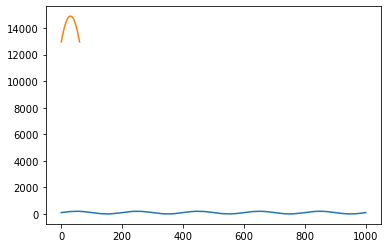

In [2]:
os.chdir(".."), os.chdir("..")   # move two directories up
%run color_scheme.ipynb
os.chdir(cor_mx_by_pop_density_directory)    # return to original directory
%run get_scaled_correlation.ipynb

## Control
Set variables to "True" to trigger the action described by the comment and the variable's name.

In [3]:
show_correlation_matrix_big = False

## Function to calculate the probability of correlations between two arrays

In [4]:
def sort_AdmUnitIDs_by_population_density(AdmUnitIds):
    county_by_population_density = dict()
    for AdmUnitID, county in counties_geography.items():
        if county['population_density'] in county_by_population_density.keys():
            raise Exception("The population density " + str(county['population_density']) +
                            "seems to be relate to two counties")
        else:
            county_by_population_density[county['population_density']] = AdmUnitID
    pop_densitys = list(county_by_population_density.keys())
    pop_densitys.sort()
    AdmUnitIds = list()
    for e in pop_densitys:
        AdmUnitIds.append(county_by_population_density[e])

In [5]:
AdmUnitIds = list(covid19.keys())
# sort_AdmUnitIDs_by_population_density(AdmUnitIds)

In [6]:
def get_correlation_matrix(get_sum_of_all_counties_correlations, max_shift):
    correlation_matrix = [[0 for c2 in range(len(AdmUnitIds))]
                          for c1 in range(len(AdmUnitIds))]
    for AdmUnitId1 in AdmUnitIds:
        for AdmUnitId2 in AdmUnitIds:
            if AdmUnitId1 == AdmUnitId2: continue
            if (correlation_matrix[AdmUnitIds.index(AdmUnitId1)]
                [AdmUnitIds.index(AdmUnitId2)] != 0): continue
            if get_sum_of_all_counties_correlations:
                correlation = get_scaled_correlation(covid19[AdmUnitId1]['incidences'],
                                                     covid19[AdmUnitId2]['incidences'],
                                                    max_shift=max_shift)[0]
                offset = (sum(correlation[:len(correlation)//2])
                          - sum(correlation[len(correlation)//2 + 1:]))
            else:
                offset = get_scaled_correlation(covid19[AdmUnitId1]['incidences'],
                                                covid19[AdmUnitId2]['incidences'],
                                                max_shift=max_shift)[3]
        
            i1, i2 = (AdmUnitIds.index(AdmUnitId1), AdmUnitIds.index(AdmUnitId2))
            correlation_matrix[i1][i2]=offset
            correlation_matrix[i2][i1]=-offset
    return correlation_matrix

In [7]:
correlation_matrizes = list()
for config in [(True, 200), (False, 50), (False, 30), (False, 14)]:
    correlation_matrizes.append(get_correlation_matrix(config[0], config[1]))

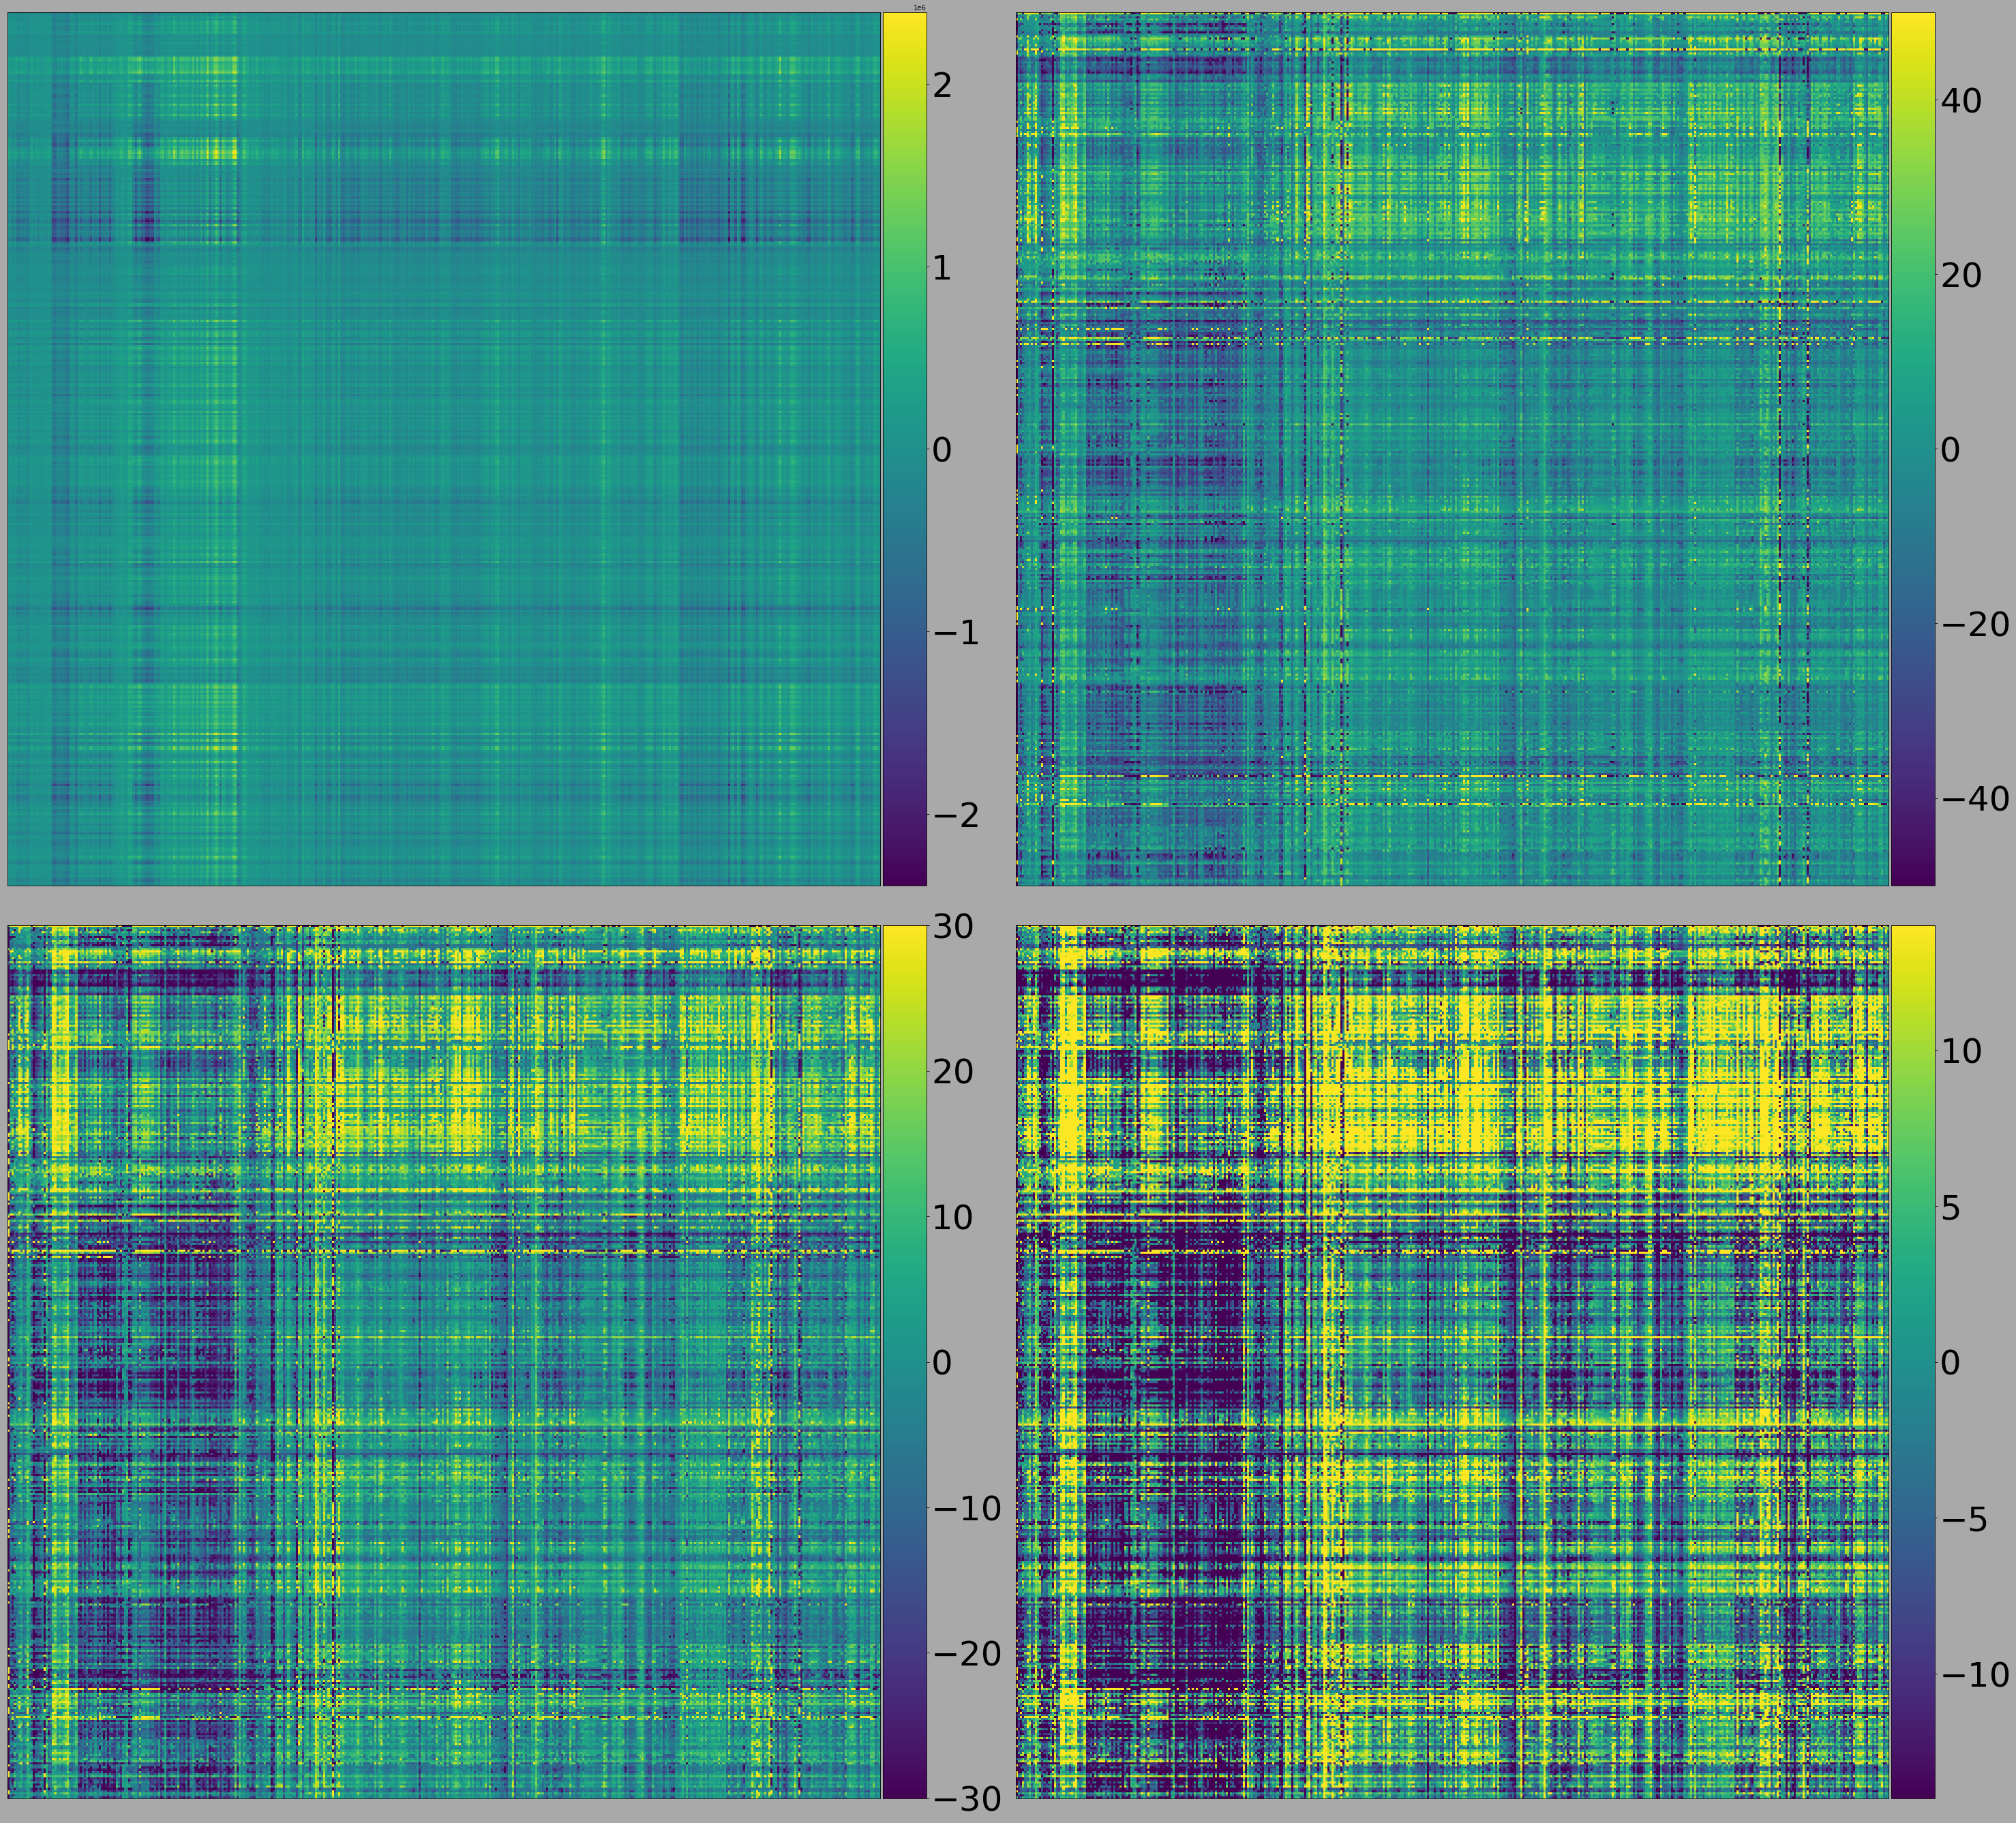

In [8]:
fig, ax = plt.subplots(2, 2, figsize = (40, 50), facecolor='darkgrey')
fig.tight_layout(h_pad=-90, w_pad=10)
i = 0
for correlation_matrix in correlation_matrizes:
    axis = ax[i//2][i%2]
    im1 = axis.matshow(correlation_matrix, interpolation='None')
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=50)
    i+=1

In [9]:
if show_correlation_matrix_big:
    matfig = plt.figure(figsize=(20,20))
    plt.matshow(get_correlation_matrix(True, 100), fignum=matfig.number)
    plt.colorbar()

In [10]:
average_correlations = dict()
for row_index in range(len(correlation_matrix)):
    row = correlation_matrix[row_index]
    AdmUnitID = AdmUnitIds[row_index]
    # Because the row represents the shift of the second
    # county relative to the first, ralated to this row,
    # we need to take minus to get the average shift of the county
    # relative to all others
    average_correlations[AdmUnitID]=-(sum(row)/len(row))

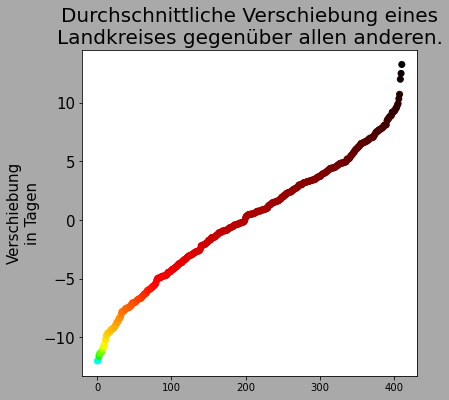

In [11]:
plt.figure(figsize=(6, 6), facecolor='darkgrey')    # enlarge plot
average_correlations_copy = list(average_correlations.values()).copy()
average_correlations_copy.sort()
# scale average_correlation_copy to calculate the colors
average_correlations_copy_scaled = [(c-average_correlations_copy[0])*
                                   (2000//average_correlations_copy[-1]) 
                                   for c in average_correlations_copy]

plt.title("Durchschnittliche Verschiebung eines\nLandkreises gegenüber allen anderen.",
         fontsize=20)
plt.ylabel("Verschiebung\nin Tagen", fontsize=15)
plt.yticks(fontsize=15)

colors = list()
for avg_correlation in average_correlations_copy_scaled:
    colors.append(color_scheme(avg_correlation, average_correlations_copy_scaled))
plt.scatter([i for i in range(len(average_correlations_copy))],
            average_correlations_copy, color=colors)
#plt.savefig("media/raw_pictures/incidences_sums_counties_distribution.png",
            #facecolor="darkgrey", bbox_inches=Bbox([[-0.7,0.4],[5.7,6]]))

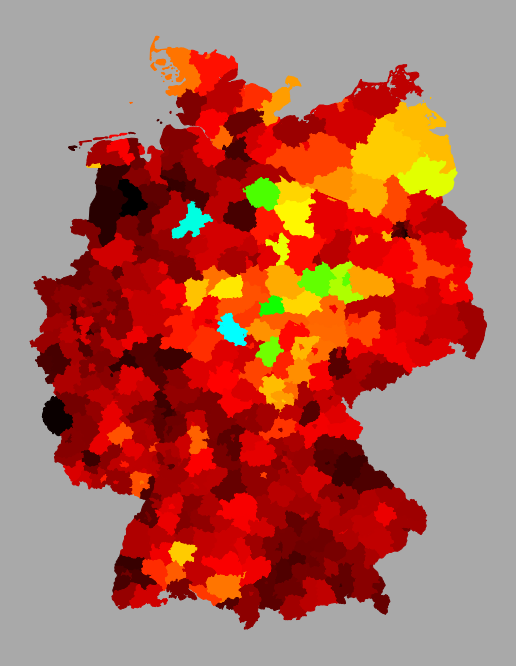

In [12]:
plt.figure(figsize=(9, 12), facecolor='darkgrey')    # enlarge plot
ax = plt.axes(frameon=False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('darkgrey')
for AdmUnitId, correlation in average_correlations.items():
    scalled_correlation=((correlation-average_correlations_copy[0])*
                         (2000//average_correlations_copy[-1]))
    for polygon in counties_geography[AdmUnitId]['geometry']:
        x,y = np.array(polygon).T
        plt.fill(x, y,
                 color=color_scheme(scalled_correlation, average_correlations_copy_scaled))
#plt.savefig("media/raw_pictures/incidences_sums_counties.png",
            #facecolor="darkgrey", bbox_inches=Bbox([[1,1.5],[8,10.5]]))